# For existing experiment data, forward propagate the next few projections 

In [1]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

INFO:Using multiprocessing.cpu_count() to determine the number of availible CPUs.
INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [3]:
#load data
dc = DataContainer('trabecular_bone_9.h5')

INFO:Inner axis found in dataset base directory. This will override the default.
INFO:Outer axis found in dataset base directory. This will override the default.
INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [4]:
#save copy of origial geometry
projections = dc.projections
dc_copy = copy.deepcopy(dc)
geometry_real = dc_copy.geometry
rotations_real = dc_copy.geometry.rotations
joff = dc_copy.geometry.j_offsets
koff = dc_copy.geometry.k_offsets

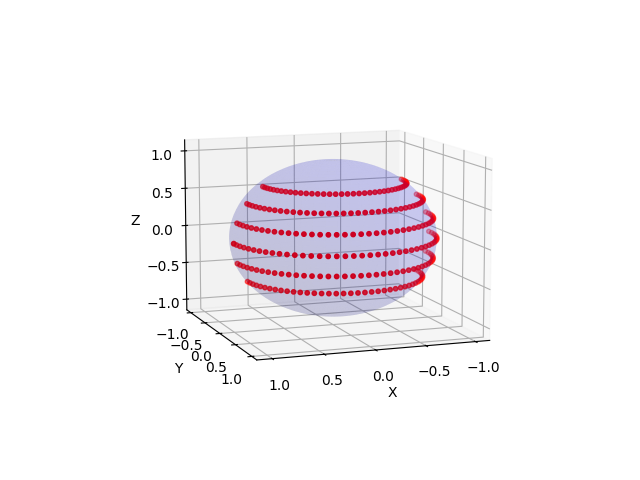

In [5]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

In [6]:
# indices are calculated based on max-min sampling strategy, then m decides how many projections for reconstruction, n decides how many next projections for prediction
m = 60
n = 5
indices_first_120 = [20,   0,  51,  71,  92, 112, 172, 192,  41,  61,  81, 100,  13,
        33, 149, 129, 221, 241, 118, 210, 230,   9, 203,  29, 139, 183,
       176, 196, 162,  85, 105, 167, 187, 158,   4,  24, 145,  96, 135,
       214, 234,  46,  66, 245, 225, 122,  56, 154,  76,  16,  37, 125,
       132, 142, 179, 199,  89, 108, 115, 217, 237,   6,   2,  11,  18,
        22,  26,  31,  35, 160, 152, 156, 164, 201, 127, 137, 147, 169,
       181, 185, 189, 174, 194,  87, 110, 120,  94,  98, 102,  83, 208,
       212, 219, 223, 227, 232, 239, 243,  48,  64,  69,  43,  53,  58,
        73,  78,  14,   1,   3,   5,   7,   8,  10,  12,  15,  17,  21,
        23,  25,  27, 28,  32,  34,  38,  39,  19,  30,  36, 128, 124,
       126, 131, 134, 136, 138, 140, 141, 143, 144, 146, 148, 150, 151,
       153, 157, 159, 161, 163, 170, 178]
indices_to_keep = indices_first_120[:m]
indices_to_predict = indices_first_120[m:m+n]

In [7]:
indices_to_predict

[237, 6, 2, 11, 18]

In [8]:
indices_to_delete = [i for i in range(247) if i not in indices_to_keep]

In [9]:
for i in sorted(indices_to_delete, reverse=True):
    del projections[i]

In [10]:
#projections used for reconstruction
projections

Field,Size,Data
data,"(60, 65, 55, 8)",4fcd09 (hash)
diode,"(60, 65, 55)",a9911d (hash)
weights,"(60, 65, 55, 8)",8802a7 (hash)
Number of pixels j,1,65
Number of pixels k,1,55


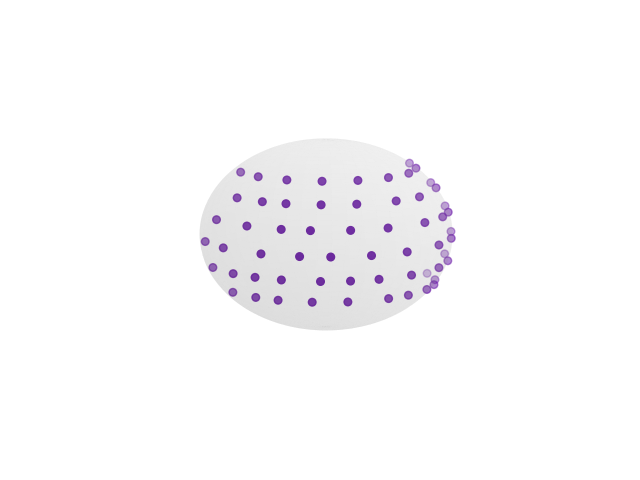

In [11]:
#plot the remaining projections 
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2 - np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)
color_values = np.arange(len(x))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1)
sc = ax.scatter(x, y, z, color='#6817a6', s=30)  
ax.set_axis_off()
ax.grid(False)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.view_init(elev=10, azim=70)
plt.tight_layout()
plt.show()

# mumott reconstruction

In [12]:
import h5py
from IPython.display import display
from ipywidgets import interact
from mumott.data_handling import DataContainer
from mumott.output_handling import ProjectionViewer
from mumott.output_handling.saving import dict_to_h5
from mumott.methods.basis_sets import SphericalHarmonics, GaussianKernels
from mumott.methods.projectors import SAXSProjector, SAXSProjectorCUDA
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

In [18]:
import torch
basis_set = SphericalHarmonics(ell_max=8)
projector = SAXSProjectorCUDA(dc.geometry) if torch.cuda.is_available() else SAXSProjector(dc.geometry)
ResidualCalculator = GradientResidualCalculator(
                                data_container=dc,
                                basis_set=basis_set,
                                projector=projector)
loss_function = SquaredLoss(ResidualCalculator)
regularizer = Laplacian()
loss_function.add_regularizer(name='laplacian',
                              regularizer=regularizer,
                              regularization_weight=1)
optimizer = LBFGS(loss_function, maxiter=20)

In [19]:
results = optimizer.optimize()

 70%|███████   | 14/20 [00:23<00:10,  1.71s/it]


In [20]:
reconstruction = results['x']

In [21]:
# new geometry
reduced_geometry = dc.geometry

In [22]:
sorted_indices_to_keep = sorted(indices_to_keep)
sorted_indices_to_predict = sorted(indices_to_predict)

In [23]:
inner_angles = np.loadtxt('bone_in_ang.txt')
outer_angles = np.loadtxt('bone_out_ang.txt')

In [24]:
# sort the indices
inner_angles_new_list = np.array(inner_angles.tolist())[sorted_indices_to_predict].tolist()
outer_angles_new_list = np.array(outer_angles.tolist())[sorted_indices_to_predict].tolist()
rotations_real_new_list = np.array(rotations_real)[sorted_indices_to_predict].tolist()
joff_new_list = np.array(joff)[sorted_indices_to_predict].tolist()
koff_new_list = np.array(koff)[sorted_indices_to_predict].tolist()

# forward propagation

In [25]:
# build a new 'geometry', refer to https://mumott.org/tutorials/simulating_samples.html
from mumott.core.geometry import GeometryTuple
geometry = Geometry()

number_of_projections = n

for i in range(number_of_projections):
    geometry.append(GeometryTuple())

geometry.inner_angles = inner_angles_new_list
geometry.outer_angles = outer_angles_new_list
geometry.p_direction_0 = np.array([0, 0, 1])
geometry.j_direction_0 = np.array([0, 1, 0])
geometry.k_direction_0 = np.array([1, 0, 0])
geometry.inner_axes = np.array([-1, 0, 0])
geometry.outer_axes = np.array([0, -1, 0])
geometry.detector_direction_positive_90 = np.array([0, 1, 0])
geometry.j_offsets = joff_new_list
geometry.k_offsets = koff_new_list

geometry.volume_shape = reconstruction.shape[0:3]
geometry.detector_angles = np.loadtxt('detector_angles.txt')
geometry.projection_shape = np.array((65, 55))
geometry.write('bone_user_geometry.geo')

INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.


In [26]:
geometry

Field,Size,Data
rotations,5,7b6afa (hash)
j_offsets,5,de8eeb (hash)
k_offsets,5,6a0502 (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[0. 1. 0.]
k_direction_0,3,[1. 0. 0.]
inner_angles,5,805490 (hash)
outer_angles,5,d9066e (hash)
inner_axes,5,18e9dc (hash)
outer_axes,5,c2dcf0 (hash)


In [30]:
projector = SAXSProjectorCUDA(geometry) if torch.cuda.is_available() else SAXSProjector(geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(reconstruction.astype(np.float64)))

In [31]:
forward_projections.shape

(5, 65, 55, 8)

In [32]:
basis_set

Field,Size,Data
"Maximum ""ell""",1,8
"""ell"" indices",45,[0 2 ... 8 8]
"""emm"" indices",45,[ 0 -2 ... 7 8]
Coefficient projection matrix,"(5, 8, 45)",[[[ 1. 0.71 ... -0.06 0.04] [ 1. 1.72 ... -0.29 -0.09] ... [ 1. -1.72 ... 0.29 -0.09] [ 1. -0.71 ... 0.06 0.04]] [[ 1. 0.64 ... -0.05 0.34] [ 1. 1.55 ... -1.15 -0.64] ... [ 1. -1.55 ... 1.15 -0.64] [ 1. -0.64 ... 0.05 0.34]] ... [[ 1. 0.11 ... 1.47 2.07] [ 1. 0.27 ... 1.2 0.49] ... [ 1. -0.27 ... -1.2 0.49] [ 1. -0.11 ... -1.47 2.07]] [[ 1. 0.56 ... 0.13 -0.17] [ 1. -0.4 ... 0.2 0.05] ... [ 1. 1.9 ... -0.54 2.04] [ 1. 1.51 ... -1.6 -0.9 ]]]
Hash,17,fd8ab2
